In [15]:
### import modules
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from utils import calculate_dissim, laplacian_dissim, calculate_dissim_unmatched
import pandas as pd
import random
from myst_nb import glue

# Unmatched Networks

We will run the same kernels on the unmatched networks from the [MaMI dataset](https://www.biorxiv.org/content/10.1101/2022.03.11.483995v1) {cite}`suarez2022taxonomy`, then compare their discriminability index.

First, let's load in the data. For the sake of time, we only use two orders with the most samples (Chiroptera and Primates), then randomly select half of the graphs to run our analysis on.

## Load Data

In [16]:
# HIDE CELL
from pathlib import Path

graphs_all = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs_all[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

random.seed(3)

# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders_all = info_df.pop("Order").to_list()

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders_all[i] == 'Artiodactyla':
        orders_all[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders_all[i]

labels_all = list(map(order_mapper.get, species_list))

# get subset of labels, graphs
orders = ['Chiroptera', 'Primates']
#orders = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']
ind_ch = []
ind_pr = []
labels = []

for i, label in enumerate(labels_all):
    if label == 'Chiroptera':
        #labels.append(label)
        ind_ch.append(i)
    elif label == 'Primates':
        #labels.append(label)
        ind_pr.append(i)

ind_ch_samp = random.sample(ind_ch, len(ind_ch)//2)
ind_pr_samp = random.sample(ind_pr, len(ind_pr)//2)

ind = ind_ch_samp + ind_pr_samp
ind.sort()
graphs = graphs_all[ind]
labels = list(np.array(labels_all)[ind])

mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(y))

225


Now similarly to the process for matched networks, we generate dissimilarity matrices for each of the kernels and visualize them with the [heatmap](https://microsoft.github.io/graspologic/latest/reference/reference/plotting.html#heatmap) function in Graspologic, sorting the matrix by their labels. All dissimilarity matrices are scaled from 0 to 1 by dividing by its maximum value.

By default, we only display dissimilarity matrices for the Density kernel, the Edge weight kernel, the Laplacian spectral kernel, and the Latent distribution test kernel, but all results can be expanded for viewing.

## Global Properties

### Density

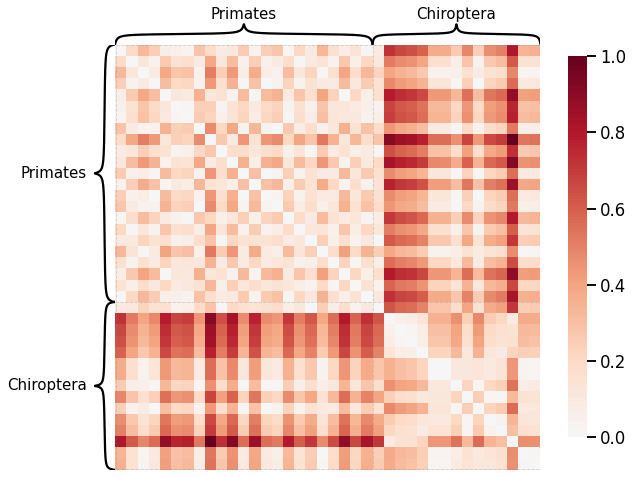

In [18]:
# HIDE CODE
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

ax = heatmap(scaled_density_dissim, inner_hier_labels=labels, hier_label_fontsize=15, context="talk")
ax.figure.set_facecolor('w')

### Average Edge Weight

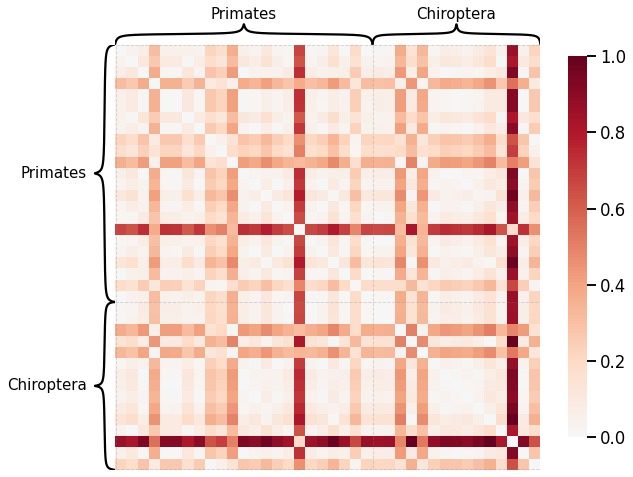

In [19]:
# HIDE CELL
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

ax = heatmap(scaled_avgedgeweight_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Average of the Adjacency Matrix

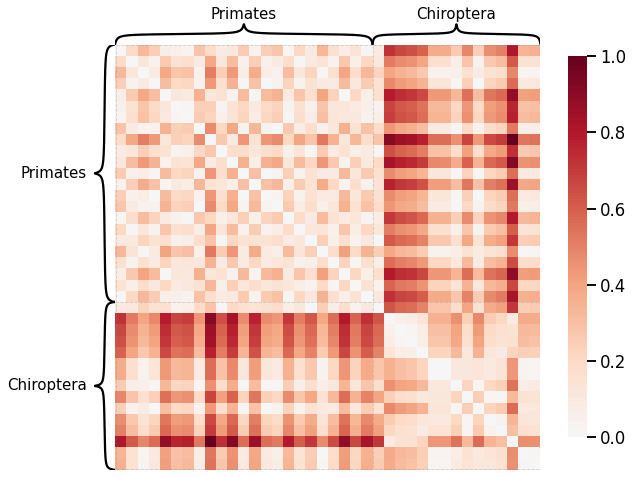

In [20]:
# HIDE CELL
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

ax = heatmap(scaled_avgadjmat_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Laplacian Spectral Distance
Each network is transformed using pass-to-ranks, and the L2 norm of the difference between the sorted eigenspecta is calculated.

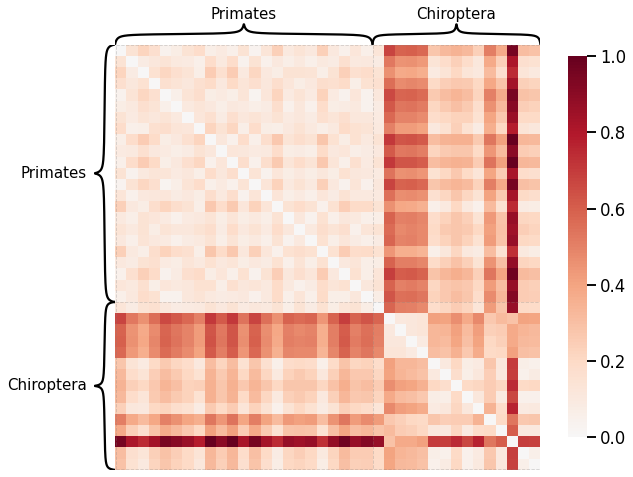

In [21]:
# HIDE CODE
scaled_lap_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', normalize=True)

ax = heatmap(scaled_lap_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

## Node-wise Properties

### Node Degrees

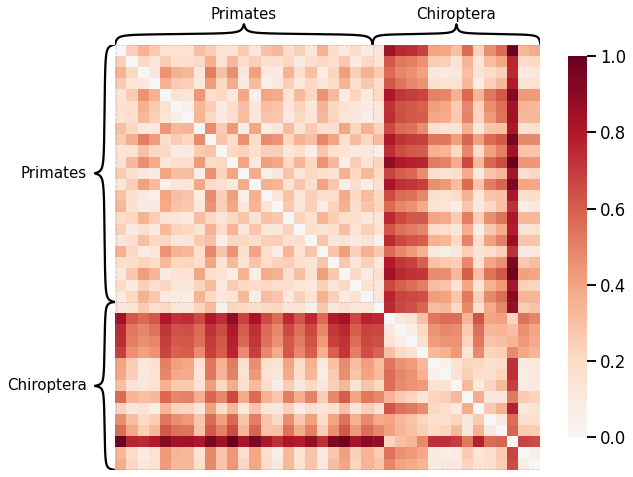

In [22]:
# HIDE CELL
scaled_nodedeg_dissim = calculate_dissim_unmatched(graphs, method="degree", normalize=True)

ax = heatmap(scaled_nodedeg_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Node Strength

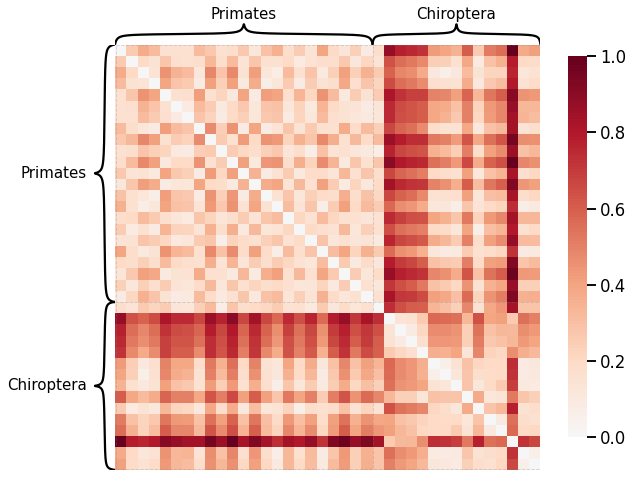

In [23]:
# HIDE CELL
scaled_nodestr_dissim = calculate_dissim_unmatched(graphs, method="strength", normalize=True)

ax = heatmap(scaled_nodestr_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

## Edge-wise Properties

### Edge weight

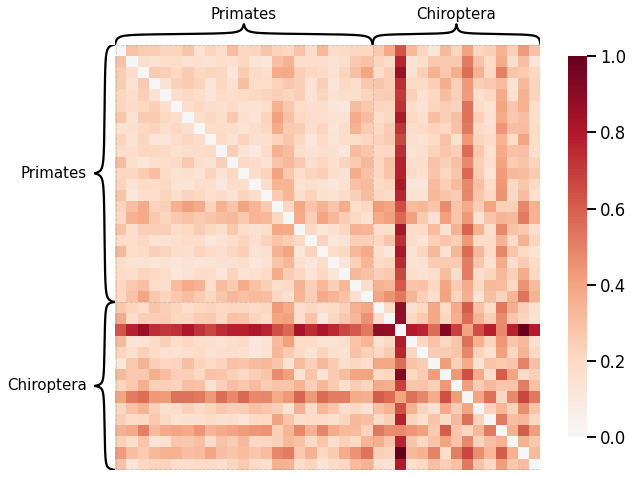

In [24]:
# HIDE CODE
scaled_edgeweight_dissim = calculate_dissim_unmatched(graphs, method="edgeweight", normalize=True)

ax = heatmap(scaled_edgeweight_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

## Latent Distribution Test
Instead of using omnibus embedding that assumes the nodes are matched, we will use the [latent distribution test](https://microsoft.github.io/graspologic/latest/reference/reference/inference.html#graspologic.inference.latent_distribution_test) from Graspologic that determines whether two random dot product graphs with no known matching between the vertices have the same distributions of latent positions. 

100%|██████████| 37/37 [1:00:54<00:00, 98.78s/it] 


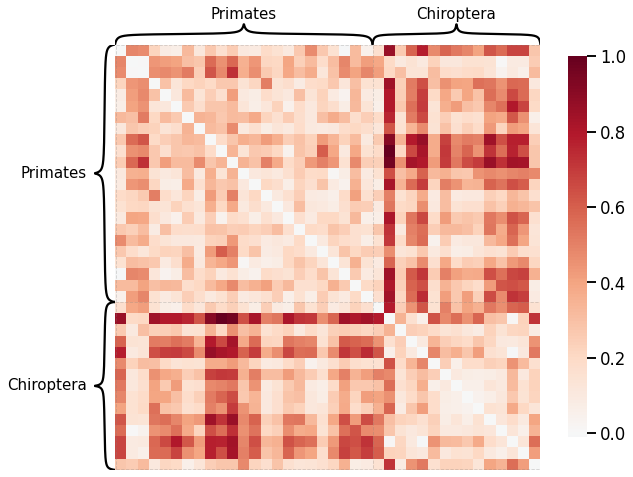

In [6]:
# HIDE CODE
from graspologic.inference import latent_distribution_test
from graspologic.plot import heatmap
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.utils import largest_connected_component
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

ase_graphs = []
for i, graph in enumerate(graphs):
    lcc_graph = largest_connected_component(graph)
    ase_graph = AdjacencySpectralEmbed(n_components=4).fit_transform(lcc_graph)
    ase_graphs.append(ase_graph)

# calculate alignments
latent_dissim = np.zeros((len(ase_graphs), len(ase_graphs)))
Qs = []
for j in tqdm(range(0, len(ase_graphs) - 1)):
    for i in range(j+1, len(ase_graphs)):
        statistic, _, misc_dict = latent_distribution_test(ase_graphs[i], ase_graphs[j], test='mgc', metric='euclidean', \
            n_bootstraps=0, align_type='seedless_procrustes', input_graph=False)
        latent_dissim[i, j] = statistic
        Qs.append(misc_dict['Q'])

# plot heatmap
scaled_latent_dissim = latent_dissim / np.max(latent_dissim)
scaled_latent_dissim = scaled_latent_dissim + scaled_latent_dissim.T

mami_latent_dissim_fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(10, 10))
heatmap(scaled_latent_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15, ax=ax)

glue("mami_latent_dissim", mami_latent_dissim_fig, display=False)

In [9]:
# HIDE CODE
%store scaled_latent_dissim
%store Qs

Stored 'scaled_latent_dissim' (ndarray)
Stored 'Qs' (list)


# Discriminability Plot

Here we compare the discriminability index of each kernel, with that of a random matrix shown by a red dash line. The kernels are sorted from highest to lowest for easy comparison.

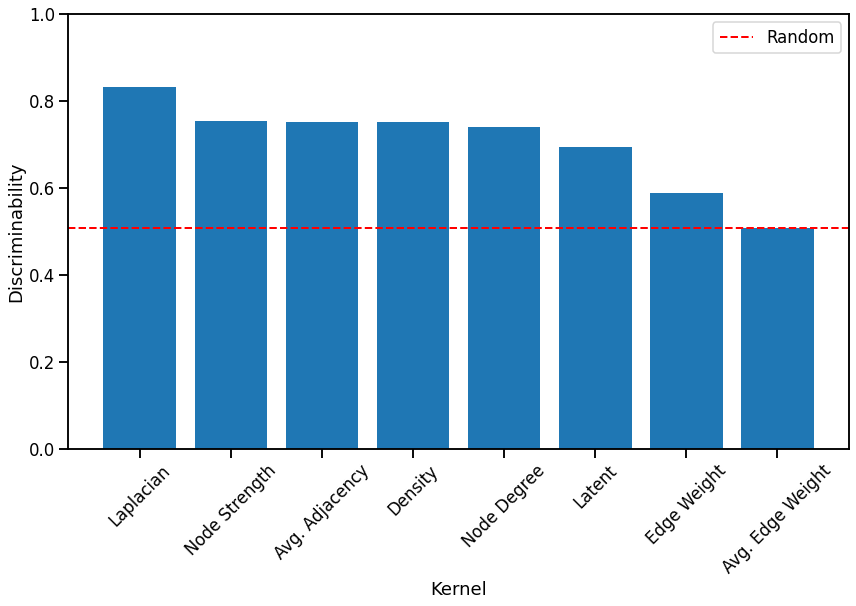

In [27]:
# HIDE CODE

from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

# construct integer labels
mapper = {}
unique_labels = np.unique(np.array(labels))
for i, label in enumerate(unique_labels):
    mapper[label] = i
y = np.array([mapper[l] for l in labels])

# construct random matrix with zero diagonal
np.random.seed(3)
scaled_random = np.random.rand(len(graphs), len(graphs))
np.fill_diagonal(scaled_random, 0)

# calculate discriminability for each kernel matrix
discrim_latent = discrim.statistic(scaled_latent_dissim, y)
discrim_density = discrim.statistic(scaled_density_dissim, y)
discrim_avgedgeweight = discrim.statistic(scaled_avgedgeweight_dissim, y)
discrim_avgadjmat = discrim.statistic(scaled_avgadjmat_dissim, y)
discrim_lap = discrim.statistic(scaled_lap_dissim, y)
discrim_nodedeg = discrim.statistic(scaled_nodedeg_dissim, y)
discrim_nodestr = discrim.statistic(scaled_nodestr_dissim, y)
discrim_edgeweight = discrim.statistic(scaled_edgeweight_dissim, y)
discrim_random = discrim.statistic(scaled_random, y)

# plot bar graph in descending order
kernels = ['Latent', 'Density', 'Avg. Edge Weight', 'Avg. Adjacency', 'Node Degree', 'Node Strength', \
    'Edge Weight', 'Laplacian']
stats = [discrim_latent, discrim_density, discrim_avgedgeweight, discrim_avgadjmat, discrim_nodedeg, \
    discrim_nodestr, discrim_edgeweight, discrim_lap]

discrim_dict = {}
for i, kernel in enumerate(kernels):
    discrim_dict[kernel] = stats[i]

sorted_discrim_dict = dict(sorted(discrim_dict.items(), key=lambda x:x[1], reverse=True))

mami_discrim_fig, ax = plt.subplots(figsize=(14,8), facecolor='w')
mami_discrim_fig = sns.set_context("talk", font_scale=1)
plt.bar(list(sorted_discrim_dict.keys()), list(sorted_discrim_dict.values()))
plt.axhline(y=discrim_random, color='r', linestyle='--', linewidth=2, label='Random')
plt.xticks(rotation=45)
plt.ylim([0, 1.0])
plt.xlabel('Kernel')
plt.ylabel('Discriminability')
plt.legend()
plt.savefig('mami_discrim_fig')

glue("mami_discrim", mami_discrim_fig, display=False)

```{glue:figure} mami_discrim_fig
:name: "mami-discrim"

Bar graph comparing the discriminability index of each kernel, sorted from highest to lowest. Most kernels perform better than random chance.
```

We observe that for unmatched networks, the Laplacian spectral kernel performs the best. Generally, kernels that use global properties of the network seem to perform better than other kernels with the exception of the Node strength kernel, which performs as well as the Average of the adjacency matrix kernel and the Density kernel. We find that the Latent distribution test kernel performs worse than some of the simple kernels, even though it took the longest. All kernels except for the Average edge weight kernel perform better than chance, and all simple kernels took less time to run than the Laplacian spectral kernel and the Latent distribution kernel.

# References
```{bibliography}
:filter: docname in docnames
:style: unsrt
```